In [ ]:
!pip install -r requirements.txt

In [66]:
import os
import base64
import numpy as np
import torch
from torch import nn
from IPython.display import Image, HTML, clear_output
import tqdm

from model import CellT, CellGrowingCA, Cell, GrowingCA
import utils
clear_output()

In [78]:
def imshow(a, fmt='jpeg'):
  display(Image(data=utils.imencode(a, fmt)))

In [79]:
#@title Cellular Automata Parameters
CHANNEL_N = 16        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 40
BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🦎" #@param {type:"string"}

EXPERIMENT_TYPE = "Growing" #@param ["Growing", "Persistent", "Regenerating"]
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

In [80]:
# Helpers
def to_rgba(x):
  return x[:,:4,:,:]

def visualize_batch(x0, x, step_i):
  x0 = utils.to_rgb(x0).numpy()
  x = utils.to_rgb(x).numpy()
  print ('X0 shape', x0.shape)
  print('X shape', x.shape)
  vis0 = np.hstack(np.transpose(x0, (0, 2,3,1)))
  vis1 = np.hstack(np.transpose(x, (0,2,3,1)))

  vis = np.vstack([vis0, vis1])
  utils.imwrite('train_log/batches_%04d.jpg'%step_i, vis)
  print('batch (before/after):')
  imshow(vis)


def make_seed(size, n=1):
  x = np.zeros([n, size, size, CHANNEL_N], np.float32)
  x[:, size//2, size//2, 3:] = 1.0
  return x

In [81]:
#@title Choose Target Image { vertical-output: true}
#url = 'https://github.com/google-research/self-organising-systems/blob/master/assets/growing_ca/planaria2_48.png?raw=true'
#target_img = load_image(url, 48)

target_img = utils.load_emoji(TARGET_EMOJI)
# imshow(utils.zoom(utils.to_rgb(target_img), 2), fmt='png')

In [82]:
#@title Initialize Input { vertical-output: true}

p = TARGET_PADDING
target_img_tensor = torch.from_numpy(target_img)

# (72,72,4)
pad_target = torch.nn.functional.pad(target_img_tensor, pad=(0,0,p,p,p,p), mode='constant', value=0)
h, w = pad_target.shape[:2]
# (16, 72, 72)
seed = np.zeros([CHANNEL_N, h, w], np.float32)
seed[3:, h//2, w//2] = 1.0

pad_target = pad_target.permute(2, 0, 1)


In [83]:
#@title Models { vertical-output: true}
ca = CellT(
    image_size = 256,
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 4,
    heads = 6,
    mlp_dim = 2048
)

origninal_ca = CellGrowingCA(CHANNEL_N)


In [84]:
# Model In Cell
caModel = Cell(ca)
origninalCAModel = Cell(origninal_ca)

In [85]:
# Training Of Cell
net = GrowingCA(origninalCAModel)

In [86]:
# Assign Model
model = net

In [87]:
# Training Initialize.
loss = nn.MSELoss()

def loss_f(x):
    x = x[:,:4,:,:] # RGB A
    return loss(x, pad_target)
    # return torch.mean(torch.square(to_rgba(x)-pad_target), [-1,-2,-3])

loss_log = []
lr = 2e-3

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.1)

pool = utils.SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))
!mkdir -p train_log && rm -f train_log/*

X0 shape (8, 3, 72, 72)
X shape (8, 3, 72, 72)
batch (before/after):


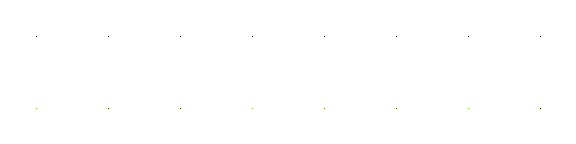

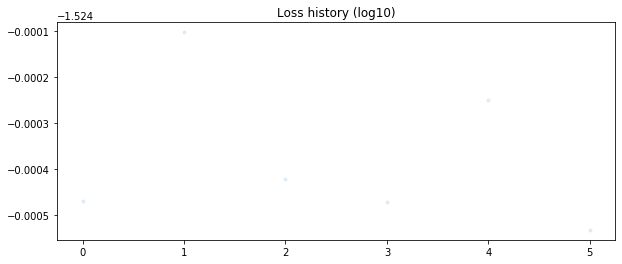

 step: 10, log10(loss): -1.524

In [88]:
model.train()

for i in range(10):
    x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)
    x0 = torch.Tensor(x0)
    optimizer.zero_grad()

    output = model(x0, 2, 3)
    loss_objective = loss_f(output)
    loss_objective.backward()
    scheduler.step()

    # DISPLAY
    lo_n = loss_objective.detach().numpy()
    o_n = output.detach()
    x0_n = x0.detach()
    
    step_i = len(loss_log)
    loss_log.append(lo_n)
    
    # if step_i%10 == 0:
    #     generate_pool_figures(pool, step_i)
    if step_i%5 == 0:
        clear_output()
        visualize_batch(x0_n, o_n, step_i)
        utils.plot_loss(loss_log)
        # export_model(ca, 'train_log/%04d'%step_i)

    print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(lo_n)), end='')